<a href="https://colab.research.google.com/github/ziyanl/FairnessPrivacyFL/blob/main/Fairness_Centralized_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import torch
import torch.utils.data as data
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import pandas as pd
import joblib

class AdultDataset(data.Dataset):
    def __init__(self, root, data_filename, test_filename=None, dataidxs=None, train=True, transform=None, target_transform=None, download=False):
        self.root = root
        self.data_filename = data_filename
        self.test_filename = test_filename
        self.dataidxs = dataidxs
        self.train = train
        self.transform = transform
        self.target_transform = target_transform
        self.download = download

        # Columns names
        columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
                   'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
                   'hours-per-week', 'native-country', 'income']

        # Load data
        self.data = pd.read_csv(os.path.join(root, data_filename), header=None, names=columns, sep=',\s*\.?\s*', engine='python')
        if test_filename is not None:
            self.test_data = pd.read_csv(os.path.join(root, test_filename), header=None, names=columns, sep=',\s', engine='python')
            self.data = pd.concat([self.data, self.test_data])

        # Handle missing data - omit entries with missing data
        self.data.replace("?", np.nan, inplace=True)
        self.data.dropna(inplace=True)

        self.target = self.data['income']
        self.data = self.data.drop(columns=['income'])

        # Handle possible periods in the test file labels
        self.target = self.target.replace({'>50K.': '>50K', '<=50K.': '<=50K'})

        # Convert target to binary labels: '>50K' becomes 1, '<=50K' becomes 0
        self.target = (self.target == '>50K').astype(int)

        if self.train:
            self._fit_preprocess_data()
        else:
            self._transform_data()

        # Truncate data if indices are provided
        if self.dataidxs is not None:
            self.data = self.data.iloc[self.dataidxs, :]
            self.target = self.target.iloc[self.dataidxs]

        # Convert data and target to numpy arrays
        self.data = self.data.to_numpy()
        self.target = self.target.to_numpy()

    def _fit_preprocess_data(self):
        # List columns that are categorical and need encoding
        categorical_features = ['workclass', 'education', 'marital-status',
                                'occupation', 'relationship', 'race', 'sex', 'native-country']

        # Create the preprocessing pipelines for both numeric and categorical data
        numeric_features = self.data.select_dtypes(include=['int64', 'float64']).columns.tolist()

        # Define transformers
        numeric_transformer = StandardScaler()
        categorical_transformer = Pipeline(steps=[
            ('onehot', OneHotEncoder(handle_unknown='ignore'))])

        # Use column transformer to apply transformations to the respective columns
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_features),
                ('cat', categorical_transformer, categorical_features)])

        # Fit and transform the data and replace the original data
        self.data = pd.DataFrame(preprocessor.fit_transform(self.data).toarray(),
                                 columns=(numeric_features +
                                          list(preprocessor.named_transformers_['cat']['onehot']
                                               .get_feature_names_out(categorical_features))))

        # Store numeric and transformed categorical feature names for later use
        self.numeric_features = numeric_features
        self.categorical_feature_names = list(preprocessor.named_transformers_['cat']['onehot']
                                              .get_feature_names_out(categorical_features))

        # Save the feature names for later use:
        joblib.dump(preprocessor, os.path.join(self.root, 'preprocessor.pkl'))
        joblib.dump((numeric_features, self.categorical_feature_names), os.path.join(self.root, 'feature_names.pkl'))

    def _transform_data(self):
        # Load the preprocessor and transform the data without refitting:
        loaded_preprocessor = joblib.load(os.path.join(self.root, 'preprocessor.pkl'))

        # Load the feature names
        self.numeric_features, self.categorical_feature_names = joblib.load(os.path.join(self.root, 'feature_names.pkl'))

        self.data = pd.DataFrame(loaded_preprocessor.transform(self.data).toarray(),
                                columns=(self.numeric_features +
                                          self.categorical_feature_names))

    def find_protected_attribute_index(self, attribute_name):
        # Find post-transformation indices of columns related to a specified attribute
        post_transform_columns = self.numeric_features + self.categorical_feature_names

        # Find columns related to the specified attribute and their indices
        attribute_related_columns = [col for col in post_transform_columns if attribute_name in col]
        indexes_of_attribute_columns = [post_transform_columns.index(col) for col in attribute_related_columns]

        return attribute_related_columns, indexes_of_attribute_columns

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (data, target) where target is index of the target class.
        """
        sample, target = self.data[index], self.target[index]

        if self.transform is not None:
            sample = self.transform(sample)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return torch.Tensor(sample), torch.Tensor([target])

    def __len__(self):
        return len(self.data)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim=1):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dims[0])
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.fc3 = nn.Linear(hidden_dims[1], output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

Epoch [1/20], Step [100/943], Loss: 0.3492
Epoch [1/20], Step [200/943], Loss: 0.3026
Epoch [1/20], Step [300/943], Loss: 0.3554
Epoch [1/20], Step [400/943], Loss: 0.3282
Epoch [1/20], Step [500/943], Loss: 0.2299
Epoch [1/20], Step [600/943], Loss: 0.4390
Epoch [1/20], Step [700/943], Loss: 0.3561
Epoch [1/20], Step [800/943], Loss: 0.2922
Epoch [1/20], Step [900/943], Loss: 0.2882
Epoch [1/20], Loss: 0.3418, Accuracy: 84.10%
Epoch [2/20], Step [100/943], Loss: 0.3073
Epoch [2/20], Step [200/943], Loss: 0.2612
Epoch [2/20], Step [300/943], Loss: 0.1953
Epoch [2/20], Step [400/943], Loss: 0.4212
Epoch [2/20], Step [500/943], Loss: 0.4974
Epoch [2/20], Step [600/943], Loss: 0.2149
Epoch [2/20], Step [700/943], Loss: 0.4523
Epoch [2/20], Step [800/943], Loss: 0.2431
Epoch [2/20], Step [900/943], Loss: 0.3444
Epoch [2/20], Loss: 0.3150, Accuracy: 85.35%
Epoch [3/20], Step [100/943], Loss: 0.3672
Epoch [3/20], Step [200/943], Loss: 0.3145
Epoch [3/20], Step [300/943], Loss: 0.2716
Epoch [

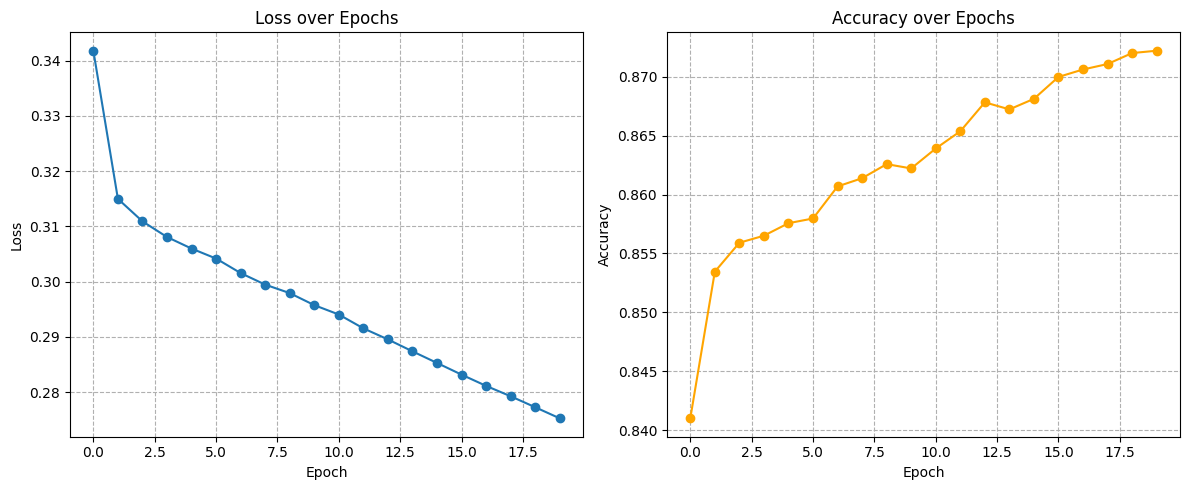

In [ ]:
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Hyperparameters
hidden_dims = [64, 32]
output_dim = 1
learning_rate = 0.001
num_epochs = 20
batch_size = 32

# Add lists to store loss and accuracy per epoch
epoch_losses = []
epoch_accuracies = []

# Load data
train_data =  AdultDataset(root='./sample_data', data_filename="adult.data", train=True)
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

# Hyperparameters
input_dim = train_data.data.shape[1]

# Initialize model, criterion, and optimizer
model = SimpleNN(input_dim, hidden_dims, output_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Check for GPU availability and set the device accordingly
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training Loop
for epoch in range(num_epochs):

    epoch_loss = 0  # Add variable to store loss per epoch

    all_preds = []
    all_labels = []

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.float().to(device), labels.float().to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs.squeeze(), labels.squeeze())

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Print loss per batch
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

        epoch_loss += loss.item()  # Add loss

        # Convert model output probabilities to binary predictions
        preds = torch.round(outputs.squeeze()).detach().cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

    avg_epoch_loss = epoch_loss / len(train_loader)  # Average loss
    epoch_losses.append(avg_epoch_loss)  # Append to list

    # Compute accuracy for the epoch
    accuracy = accuracy_score(all_labels, all_preds)
    epoch_accuracies.append(accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}, Accuracy: {accuracy * 100:.2f}%')

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

# Visualize Loss over Epochs
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), epoch_losses, marker='o')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(ls='--')

# Visualize Accuracy over Epochs
plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), epoch_accuracies, marker='o', color='orange')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(ls='--')

plt.tight_layout()
plt.show()

Accuracy: 84.71%
Confusion Matrix:
[[10431   929]
 [ 1374  2326]]
Classification Report:
              precision    recall  f1-score   support

       <=50K       0.88      0.92      0.90     11360
        >50K       0.71      0.63      0.67      3700

    accuracy                           0.85     15060
   macro avg       0.80      0.77      0.78     15060
weighted avg       0.84      0.85      0.84     15060



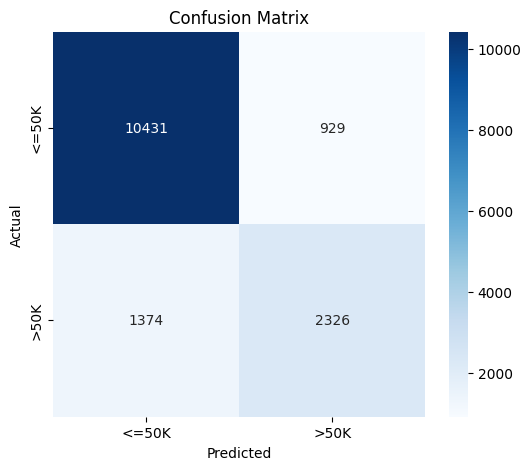

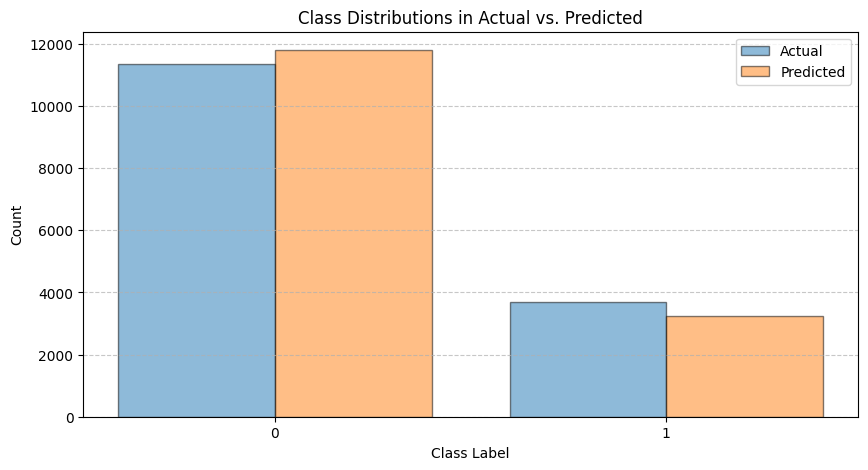

In [ ]:
# Load data
test_data = AdultDataset(root='./sample_data', data_filename="adult.test", train=False)
test_loader = DataLoader(dataset=test_data, batch_size=32, shuffle=False)

# Load the trained model
model.load_state_dict(torch.load('model.ckpt'))

# Ensure the model is set to evaluation mode
model.eval()

# Lists to store predicted and target labels
all_preds = []
all_labels = []

# Evaluation Loop
with torch.no_grad():  # Disable gradient computation during evaluation
    for inputs, labels in test_loader:
        inputs, labels = inputs.float().to(device), labels.float().to(device)

        # Forward pass
        outputs = model(inputs)

        # Convert model output probabilities to binary predictions
        preds = torch.round(outputs.squeeze()).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

# Compute evaluation metrics
accuracy = accuracy_score(all_labels, all_preds)
conf_matrix = confusion_matrix(all_labels, all_preds)
class_report = classification_report(all_labels, all_preds, target_names=['<=50K', '>50K'])

# Display metrics
print(f'Accuracy: {accuracy*100:.2f}%')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{class_report}')

# Confusion Matrix Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['<=50K', '>50K'], yticklabels=['<=50K', '>50K'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Class Distributions
all_labels = np.array(all_labels).flatten()
all_preds = np.array(all_preds).flatten()

plt.figure(figsize=(10, 5))
plt.hist([all_labels, all_preds], bins=np.arange(3)-0.5, alpha=0.5,
         label=['Actual', 'Predicted'], edgecolor='k')
plt.xticks([0, 1])
plt.legend(loc='upper right')
plt.title('Class Distributions in Actual vs. Predicted')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Equalized Odds for attribute 1:
{0.0: {'tpr': 0.6401527203308941, 'fpr': 0.11336379211878926}, 1.0: {'tpr': 0.5637342908438061, 'fpr': 0.030991735537190084}}

Equalized Odds for attribute 2:
{0.0: {'tpr': 0.5637342908438061, 'fpr': 0.030991735537190084}, 1.0: {'tpr': 0.6401527203308941, 'fpr': 0.11336379211878926}}

Equal Opportunity for attribute 1:
{0.0: {'tpr': 0.6401527203308941}, 1.0: {'tpr': 0.5637342908438061}}

Equal Opportunity for attribute 2:
{0.0: {'tpr': 0.5637342908438061}, 1.0: {'tpr': 0.6401527203308941}}

Demographic Parity for attribute 1:
{0.0: {'positive_rate': 0.2765349364344141}, 1.0: {'positive_rate': 0.09139018929371057}}

Demographic Parity for attribute 2:
{0.0: {'positive_rate': 0.09139018929371057}, 1.0: {'positive_rate': 0.2765349364344141}}

Disparate Impact for attribute 1:
{0.0: 1.0, 1.0: 0.330483339545004}

Disparate Impact for attribute 2:
{0.0: 1.0, 1.0: 3.025871141875894}


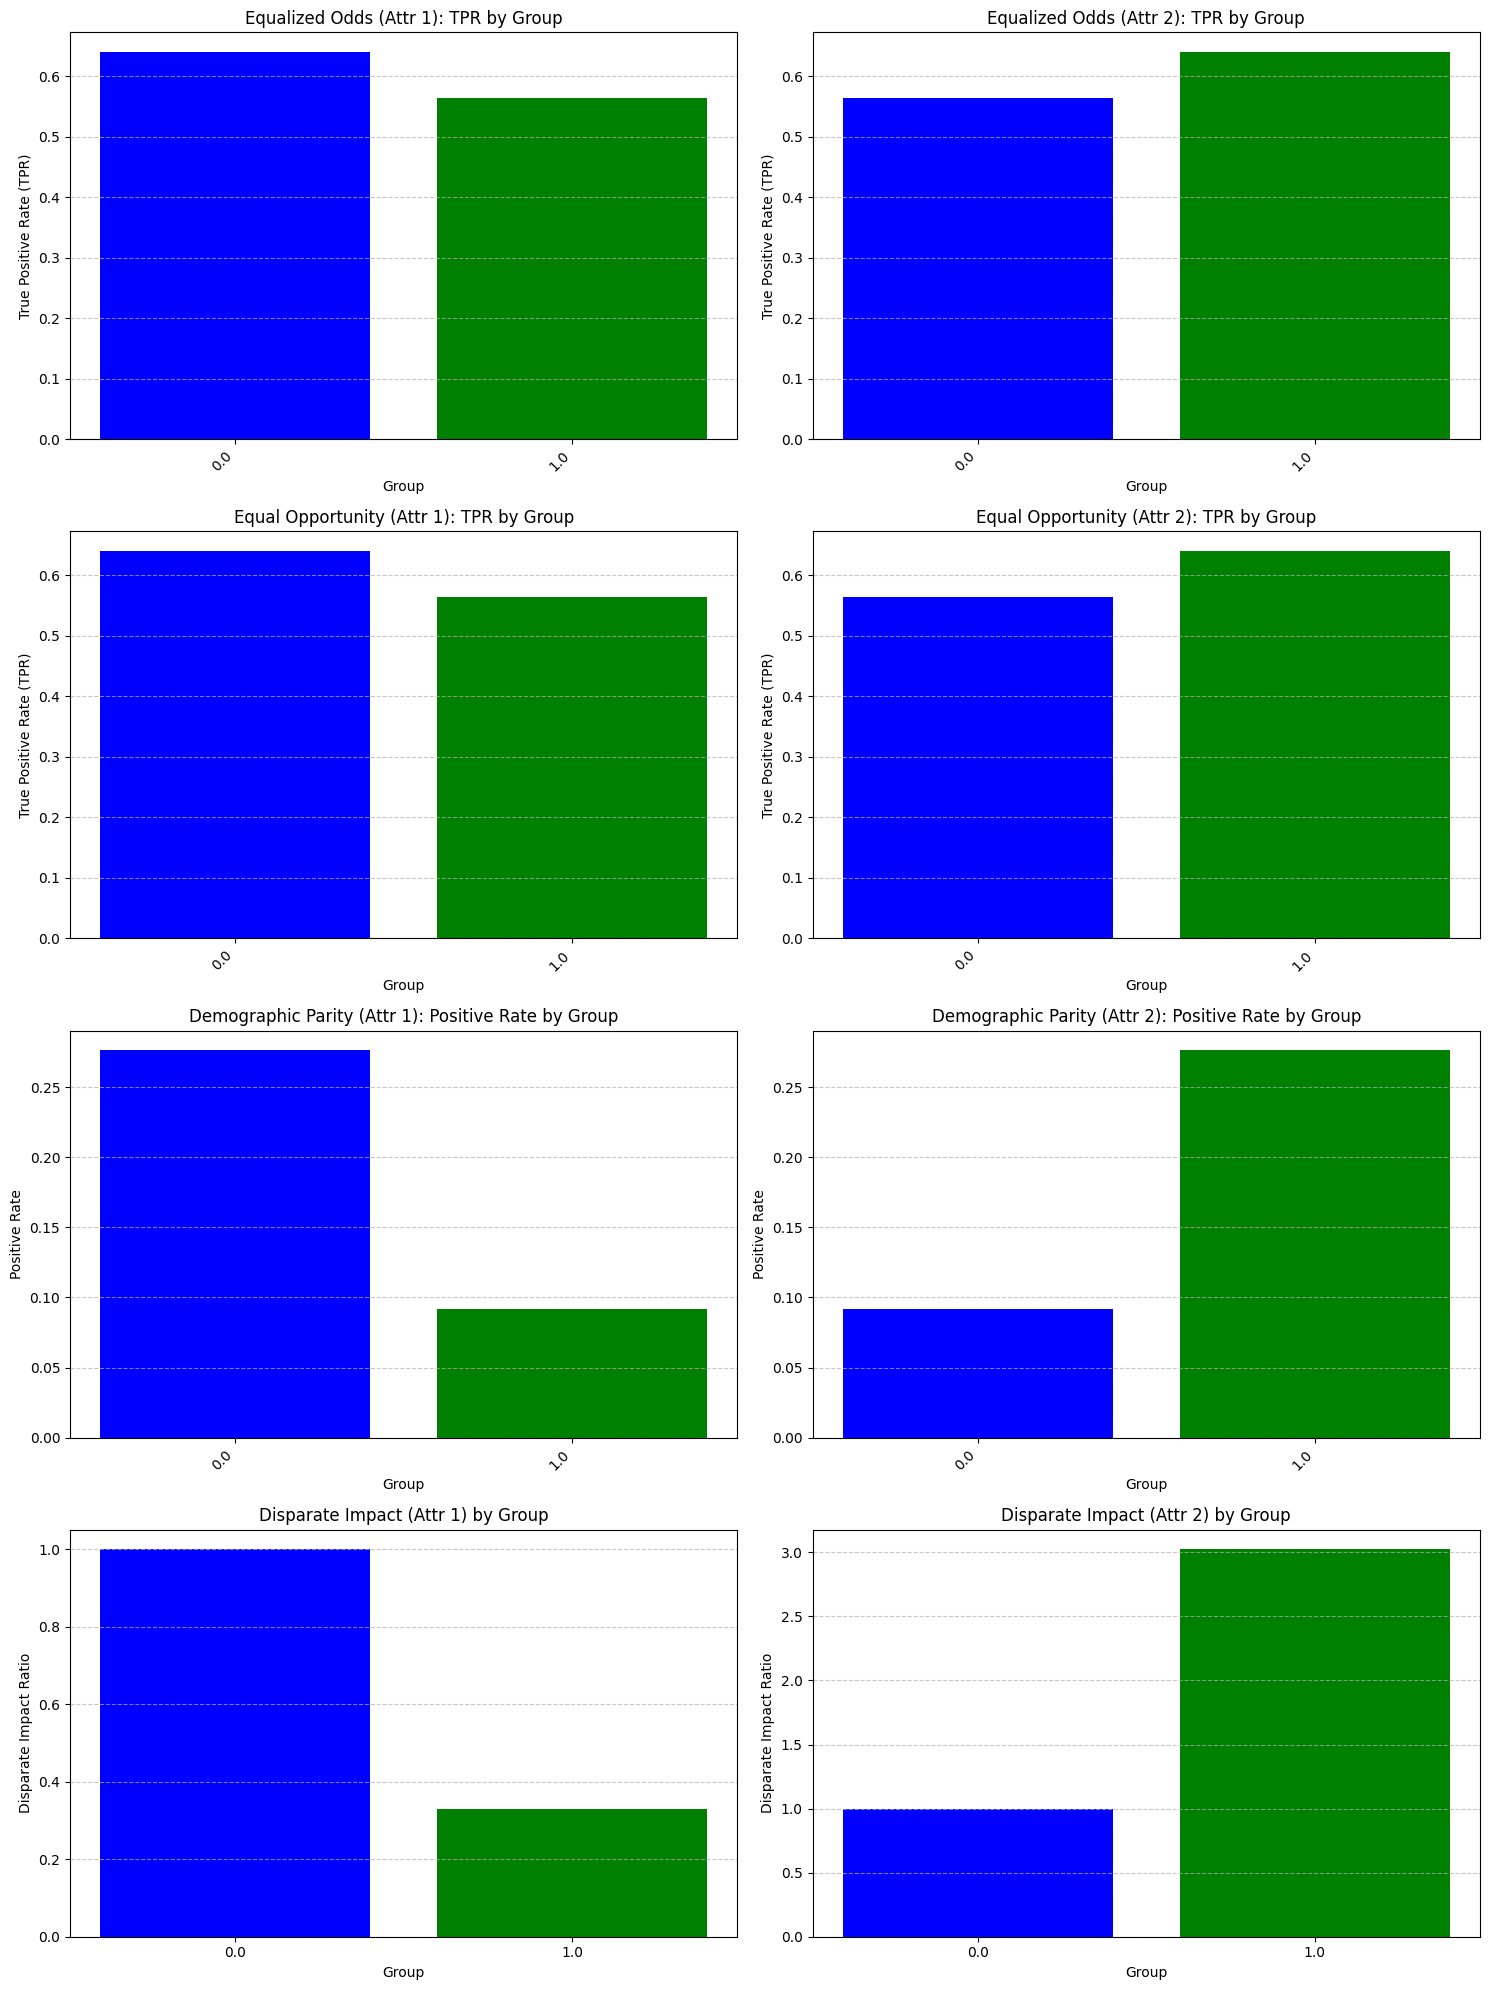

In [ ]:
# Equalized Odds
def calculate_eod(true_labels, predicted_labels, protected_attributes, attribute_index):
    unique_groups = np.unique(protected_attributes[:, attribute_index])
    group_metrics = {}

    for group in unique_groups:
        idx = (protected_attributes[:, attribute_index] == group)

        true_labels_group = true_labels[idx]
        predicted_labels_group = predicted_labels[idx]

        if len(np.unique(true_labels_group)) > 1:  # ensure both positives and negatives are present
            tn, fp, fn, tp = confusion_matrix(true_labels_group, predicted_labels_group).ravel()
            tpr = tp / (tp + fn)
            fpr = fp / (fp + tn)
        else:
            tpr = fpr = np.nan  # Not computable

        group_metrics[group] = {'tpr': tpr, 'fpr': fpr}

    return group_metrics

# Equal Opportunity
def calculate_eop(true_labels, predicted_labels, protected_attributes, attribute_index):
    unique_groups = np.unique(protected_attributes[:, attribute_index])
    group_metrics = {}

    for group in unique_groups:
        idx = (protected_attributes[:, attribute_index] == group)
        true_labels_group = true_labels[idx]
        predicted_labels_group = predicted_labels[idx]

        if len(np.unique(true_labels_group)) > 1:  # ensure both positives and negatives are present
            tn, fp, fn, tp = confusion_matrix(true_labels_group, predicted_labels_group).ravel()
            tpr = tp / (tp + fn)  # Sensitivity or True Positive Rate
        else:
            tpr = np.nan  # Not computable

        group_metrics[group] = {'tpr': tpr}

    return group_metrics

# Demographic Parity
def calculate_dop(predicted_labels, protected_attributes, attribute_index):
    unique_groups = np.unique(protected_attributes[:, attribute_index])
    group_metrics = {}

    for group in unique_groups:
        idx = (protected_attributes[:, attribute_index] == group)
        predicted_labels_group = predicted_labels[idx]

        positive_rate = np.mean(predicted_labels_group == 1)

        group_metrics[group] = {'positive_rate': positive_rate}

    return group_metrics

# Disparate Impact
def calculate_dip(predicted_labels, protected_attributes, attribute_index):
    unique_groups = np.unique(protected_attributes[:, attribute_index])
    group_metrics = calculate_dop(predicted_labels, protected_attributes, attribute_index)

    reference_group = unique_groups[0]  # Assume the first group is the reference group
    reference_rate = group_metrics[reference_group]['positive_rate']

    disparate_impact = {}

    for group in unique_groups:
        if reference_rate == 0:  # Prevent division by zero
            disparate_impact[group] = np.nan  # Not computable
        else:
            disparate_impact[group] = group_metrics[group]['positive_rate'] / reference_rate

    return disparate_impact

# Compute Fairness Metrics
# Extract protected attributes from the test data
_, attribute_indices = test_data.find_protected_attribute_index('sex')
protected_attributes = test_data.data[:, attribute_indices]

# Convert predictions and labels to NumPy arrays for use with your functions
all_preds_np = np.array(all_preds)
all_labels_np = np.array(all_labels)

# Calculate the fairness metrics
eod_metrics_attr1 = calculate_eod(all_labels_np, all_preds_np, protected_attributes, 0)
eod_metrics_attr2 = calculate_eod(all_labels_np, all_preds_np, protected_attributes, 1)
eop_metrics_attr1 = calculate_eop(all_labels_np, all_preds_np, protected_attributes, 0)
eop_metrics_attr2 = calculate_eop(all_labels_np, all_preds_np, protected_attributes, 1)
dop_metrics_attr1 = calculate_dop(all_preds_np, protected_attributes, 0)
dop_metrics_attr2 = calculate_dop(all_preds_np, protected_attributes, 1)
dip_metrics_attr1 = calculate_dip(all_preds_np, protected_attributes, 0)
dip_metrics_attr2 = calculate_dip(all_preds_np, protected_attributes, 1)

# Display fairness metrics
print(f'\nEqualized Odds for attribute 1:\n{eod_metrics_attr1}')
print(f'\nEqualized Odds for attribute 2:\n{eod_metrics_attr2}')
print(f'\nEqual Opportunity for attribute 1:\n{eop_metrics_attr1}')
print(f'\nEqual Opportunity for attribute 2:\n{eop_metrics_attr2}')
print(f'\nDemographic Parity for attribute 1:\n{dop_metrics_attr1}')
print(f'\nDemographic Parity for attribute 2:\n{dop_metrics_attr2}')
print(f'\nDisparate Impact for attribute 1:\n{dip_metrics_attr1}')
print(f'\nDisparate Impact for attribute 2:\n{dip_metrics_attr2}')

# Visualize fairness metrics
def plot_metric(metric_values, key, title, ylabel, ax):
    groups = list(metric_values.keys())
    str_groups = [str(g) for g in groups]
    values = [metric_values[group].get(key, np.nan) for group in groups]  # Change here to handle non-existing keys
    ax.bar(str_groups, values, color=['blue', 'green', 'red', 'purple'])
    ax.set_xlabel('Group')
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.set_xticks(range(len(str_groups)))  # Set x-axis tick locations first
    ax.set_xticklabels(str_groups, rotation=45, ha='right')

# Create subplots
fig, axs = plt.subplots(4, 2, figsize=(15, 20))

# Plot for Attribute 1
plot_metric(eod_metrics_attr1, 'tpr', 'Equalized Odds (Attr 1): TPR by Group', 'True Positive Rate (TPR)', axs[0, 0])
plot_metric(eop_metrics_attr1, 'tpr', 'Equal Opportunity (Attr 1): TPR by Group', 'True Positive Rate (TPR)', axs[1, 0])
plot_metric(dop_metrics_attr1, 'positive_rate', 'Demographic Parity (Attr 1): Positive Rate by Group', 'Positive Rate', axs[2, 0])
# Correct the call for Disparate Impact
axs[3, 0].bar([str(k) for k in dip_metrics_attr1.keys()], list(dip_metrics_attr1.values()), color=['blue', 'green', 'red', 'purple'])
axs[3, 0].set_title('Disparate Impact (Attr 1) by Group')
axs[3, 0].set_ylabel('Disparate Impact Ratio')
axs[3, 0].set_xlabel('Group')
axs[3, 0].grid(axis='y', linestyle='--', alpha=0.7)

# Similarly for Attribute 2
plot_metric(eod_metrics_attr2, 'tpr', 'Equalized Odds (Attr 2): TPR by Group', 'True Positive Rate (TPR)', axs[0, 1])
plot_metric(eop_metrics_attr2, 'tpr', 'Equal Opportunity (Attr 2): TPR by Group', 'True Positive Rate (TPR)', axs[1, 1])
plot_metric(dop_metrics_attr2, 'positive_rate', 'Demographic Parity (Attr 2): Positive Rate by Group', 'Positive Rate', axs[2, 1])
# Correct the call for Disparate Impact
axs[3, 1].bar([str(k) for k in dip_metrics_attr2.keys()], list(dip_metrics_attr2.values()), color=['blue', 'green', 'red', 'purple'])
axs[3, 1].set_title('Disparate Impact (Attr 2) by Group')
axs[3, 1].set_ylabel('Disparate Impact Ratio')
axs[3, 1].set_xlabel('Group')
axs[3, 1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
# prompt:

class DiabetesDataset(data.Dataset):
  def __init__(self, data, labels):
    self.data = data
    self.labels = labels

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return self.data[idx], self.labels[idx]

  def __repr__(self):
    return f'DiabetesDataset({len(self)}, {self.data.shape}, {self.labels.shape})'
